In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

In [2]:
#Get working directory, target dir etc.
cwd = os.getcwd()
target_dir = 'data'


#Target csv names
csv_paid_platform_data = 'Growth Analytics Challenge - Dataset - Nov2023 - Paid Platform Data.csv'
csv_conversion_data = 'Growth Analytics Challenge - Dataset Conversion Data.csv'


#Target csv path
path_csv_paid_platform_data = os.path.join(cwd,target_dir,csv_paid_platform_data)
path_csv_conversion_data = os.path.join(cwd,target_dir,csv_conversion_data)


#Read csv and save to df
df_paid_platform_data = pd.read_csv(path_csv_paid_platform_data)
df_conversion_data = pd.read_csv(path_csv_conversion_data)

In [3]:
#Read first 3 rows of platform_data
df_paid_platform_data.head(3)

,Utm Medium,Utm Source,Traffic Week,# Impressions,# Clicks,$ Cost
0,paid-social,linkedin,2023-10-23,4881796,21954,"$169,017.58"
1,paid-social,linkedin,2023-10-16,6335386,15776,"$174,972.20"
2,paid-social,linkedin,2023-10-09,4485024,35009,"$327,466.25"


In [4]:
#Read first 3 rows of conversion_data
df_conversion_data.head(3)

,Touched Date,Utm Medium,Utm Source,Utm Campaign,# Demo Occurred,# Sales Qualified Opportunity,# Closed Won Opportunity
0,2023-10-29,paid-search,google,nam-t1_acq_searchnonbranded_google_search_coun...,2.5,0.0,0.0
1,2023-10-29,paid-listicle,peoplemanagingpeople,ww_acq_prosp_pmp_paidlist_cadpayroll-pmp-__all,2.5,2.5,0.0
2,2023-10-29,paid-social,facebook,nam-t1_consider_calculate_fb_image_all-reengag...,2.4,0.0,0.0


# Format base dataFrames

- For each question we will copy the base dataframes, rename and manipulate the dataframe as required

- To avoid repetitive transformations, we will update the base dataframe


#### df_paid_platform_data
- Format cost data
- Convert traffic week to datetime

#### df_conversion_data
- Add 'Touched Week' using the start of the week date to align with date format in df_paid_platform


In [5]:
#Format paid_platform_data
df_paid_platform_data['$ Cost'] = round(df_paid_platform_data['$ Cost'].apply(lambda x: float(x.replace('$','').replace(',',''))),0)
df_paid_platform_data['Traffic Week'] = pd.to_datetime(df_paid_platform_data['Traffic Week'])

#Format conversion_data
df_conversion_data['Touched Date'] = pd.to_datetime(df_conversion_data['Touched Date'])
df_conversion_data['Touched Week'] = df_conversion_data['Touched Date'].dt.to_period('W').apply(lambda x: x.start_time)

# Task 1: Analyzing Sales Funnel Data

## a) Time series analysis
- Perform a time series analysis on the number of demo occurrences, sales qualified opportunities, and closed won opportunities. 
- Are there any seasonality patterns in the data?
    - If so: how can we use this information for marketing strategy planning?

#### Plotting daily data
- We'll plot the funnel data including daily totals and a rolling average
- We create a function, before looping through a list, containing each KPI, then plotting the daily total & rolling average in 3 separate charts

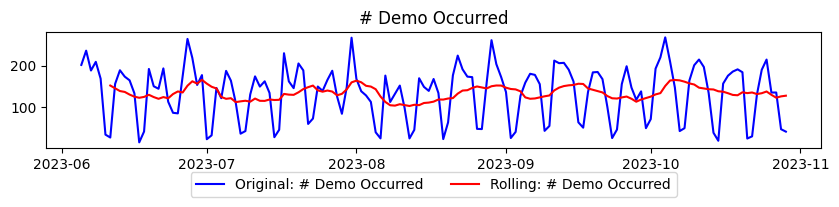

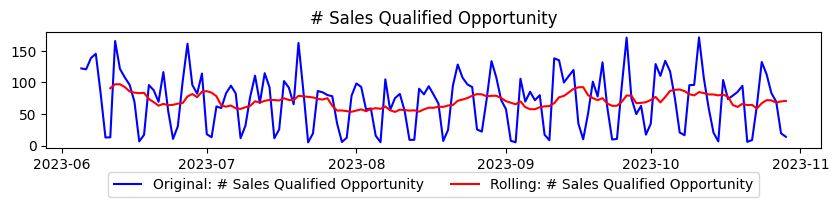

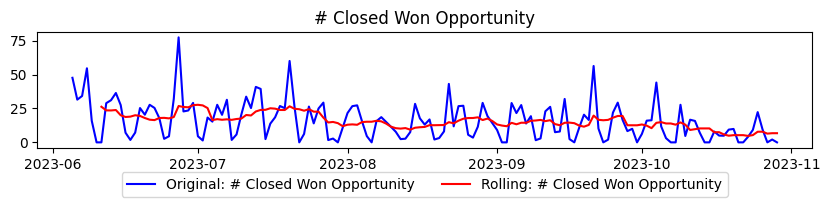

In [6]:
import matplotlib.pyplot as plt

df_tsd = df_conversion_data.copy()
df_tsd['Touched Date'] = df_tsd['Touched Date'].apply(lambda x: pd.to_datetime(x))
df_tsd = df_tsd.set_index('Touched Date')
df_tsd.sort_index(inplace=True)

#Keep relevant columns only
df_tsd_daily = df_tsd.groupby('Touched Date')[['# Demo Occurred','# Sales Qualified Opportunity','# Closed Won Opportunity']].sum()

#Create funciton to plot funnel sales data
def plot_sales_funnel_data(df, kpi):    
    #Calculate rolling mean / std
    original_kpi = df[kpi]
    rolling_mean = df[kpi].rolling(7).mean()
    rolling_std = df[kpi].rolling(7).std()

    #Plot Data
    plt.figure(figsize=(10,1.5))
    plt.plot(original_kpi, color="blue",label=f"Original: {kpi}")
    plt.plot(rolling_mean, color="red", label=f"Rolling: {kpi}")
    #plt.legend(loc="best")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fancybox=True)
    plt.title(kpi)
    plt.show()
    
kpis = ['# Demo Occurred','# Sales Qualified Opportunity','# Closed Won Opportunity']

# Plot Daily Stationarity
for kpi in kpis:
    plot_sales_funnel_data(df=df_tsd_daily, kpi=kpi)

#### Evaluation
- The funnel data shows significant patters of seasonality
- The data suggests there are no Demos / Sales / Closed opportunities on weekends
- This is highly plausible, given the 5-day work week (Mon-Fri)

#### Next Steps
- We run a time series decomposition, with a 7-day period, due to our assumption of the weekly cyclical nature of the daily data
- This decomposition shows:
    - The seasonality in the data
    - Underlying trend of the data
    - Any residuals (variation in the time series which can't be attributed to the seasonality / trend

### Run Decomposition (Daily Data)

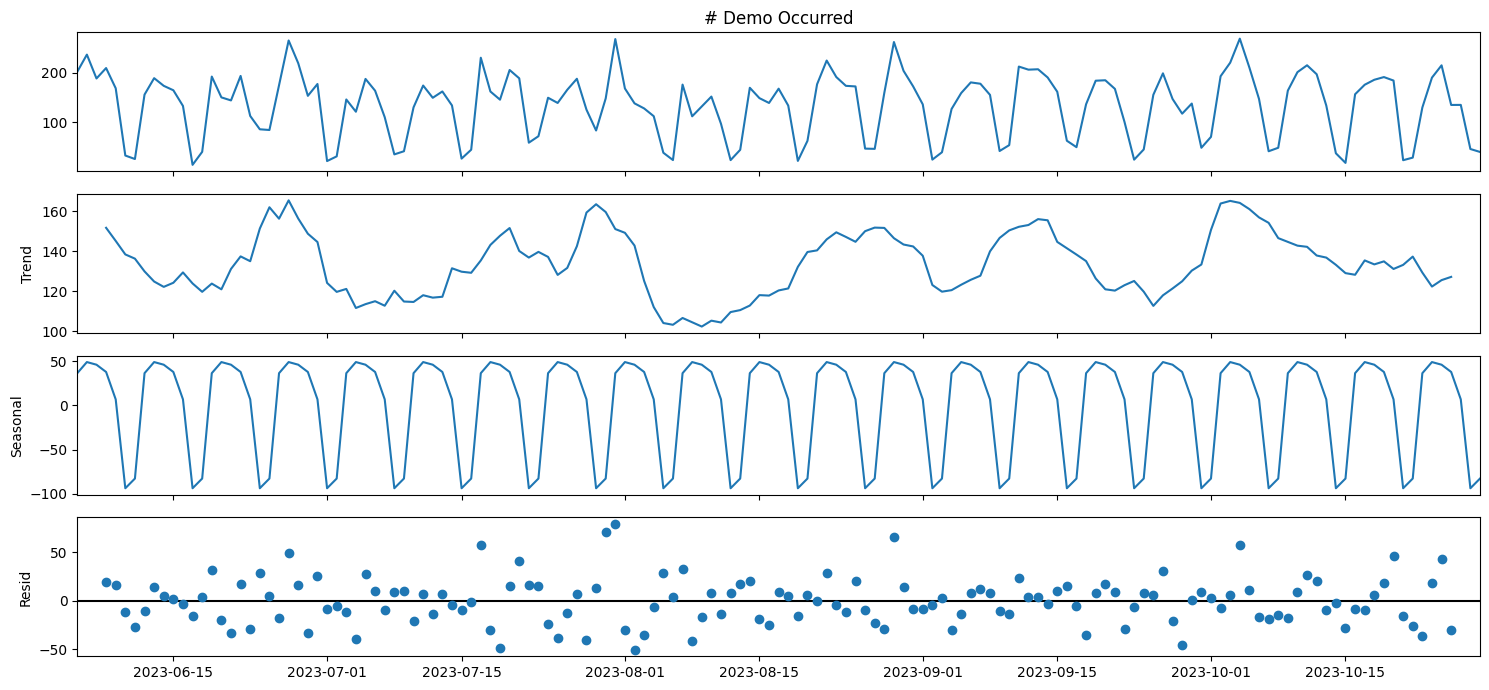

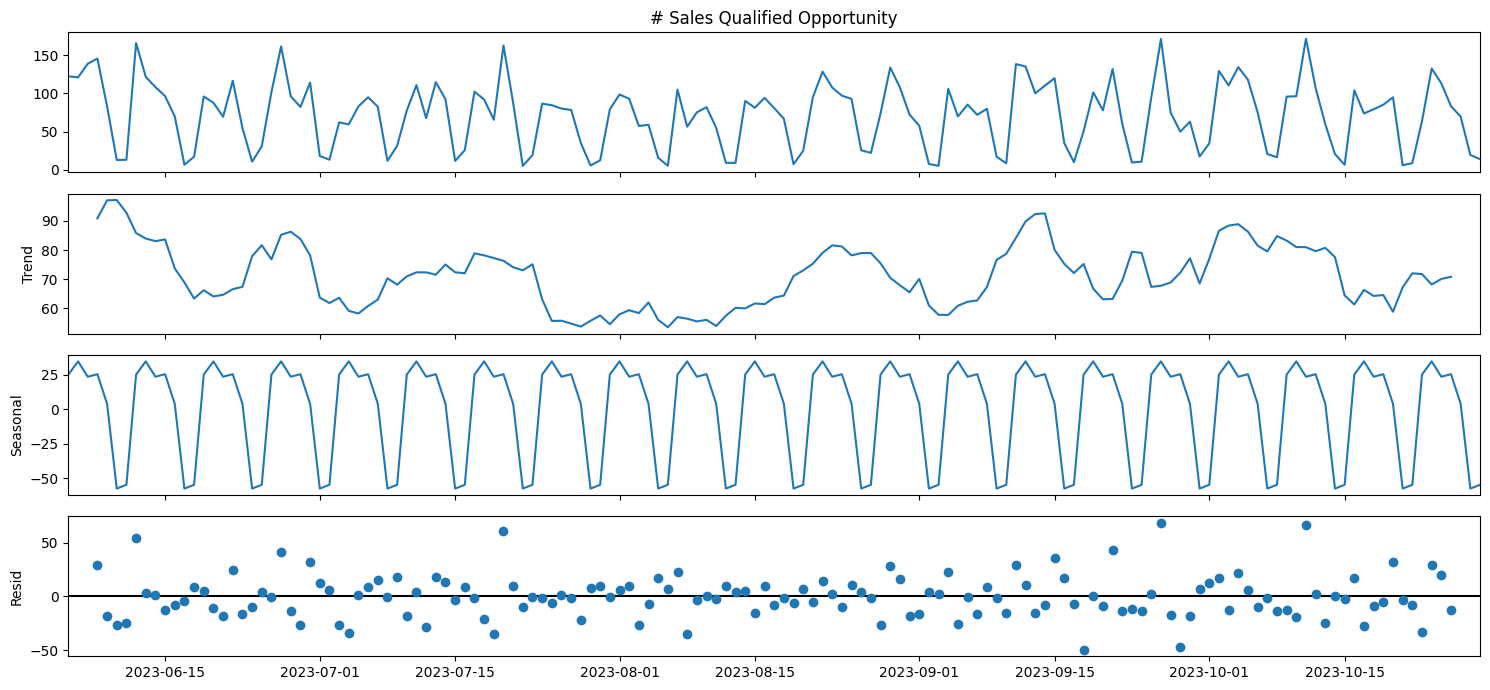

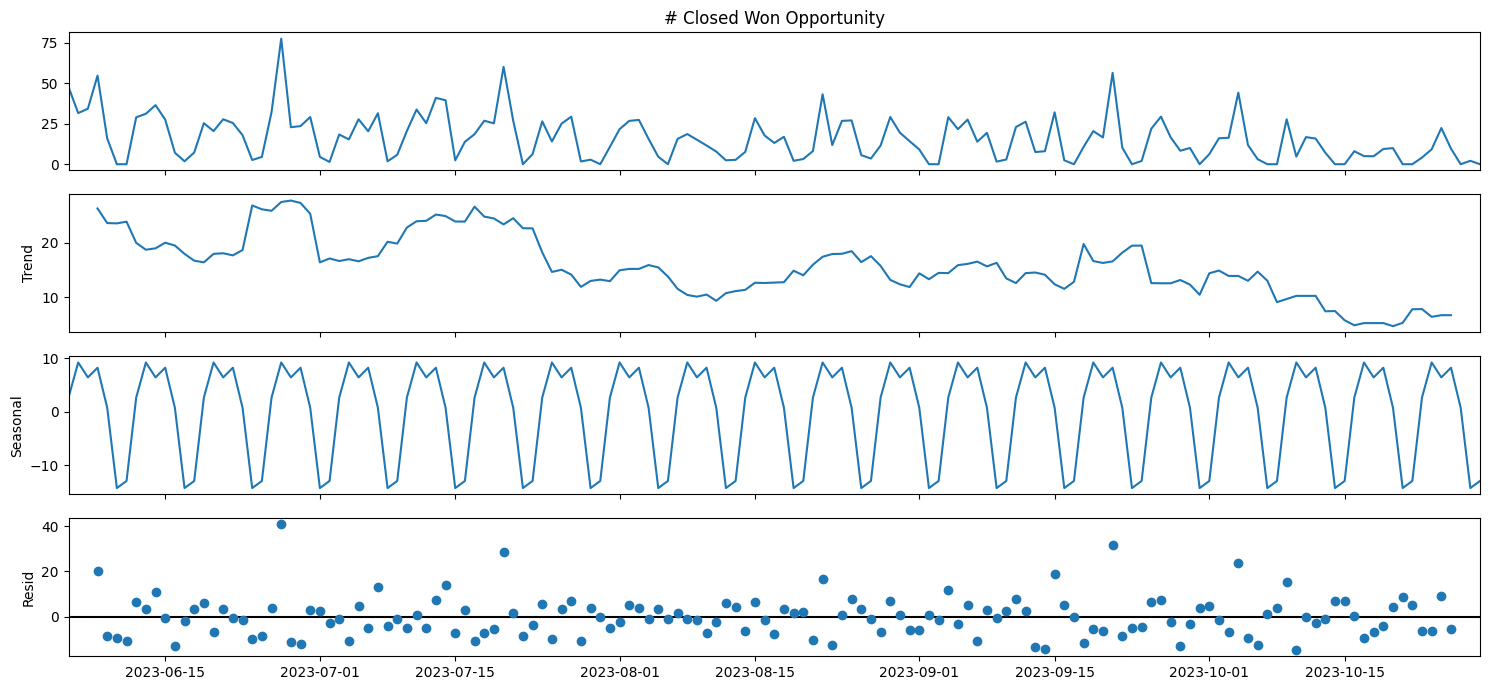

In [7]:
def timeseries_composition(df,kpi, period):
    decomposition = sm.tsa.seasonal_decompose(df[kpi], period=period)
    fig = decomposition.plot()
    fig.set_size_inches((15, 7))
    fig.tight_layout()
    plt.show()


kpis = ['# Demo Occurred','# Sales Qualified Opportunity','# Closed Won Opportunity']

for kpi in kpis:
    timeseries_composition(df=df_tsd_daily, kpi=kpi, period=7)

#### Analysis
- The decomposition confirms high daily seasonality in all 3 funnel KPIs
- The underlying trends are also very informative. We observe:
    - Demos / Sales Qualified opportunities: 
        - Generally stable over the timeframe
        - Consistently lower values at the start of the month
        - Increasing from the middle towards the end of the month, before declining again
    - Closed Opportunities:
        - Trending downwards, with a major decrease towards the end of July

#### Recommendations
- Marketing budgets should be disproportionately allocated to the working week (Mon-Fri)
- Lower proportion of budget allocated to the start of the month
- Given the stable demos / sales opportunities but lower closed opportunities:
    - We could develop many hypotheses why this is occurring, but we might consider a general reduction in budget 

## b) Funnel conversion rate
- Calculate the conversion rates for the sales funnel over time, from:
    - demo occurred to sales qualified opportunity
    - sales qualified opportunity to closed won opportunity. 
- Provide visualizations to illustrate these trends.


#### Daily funnel data

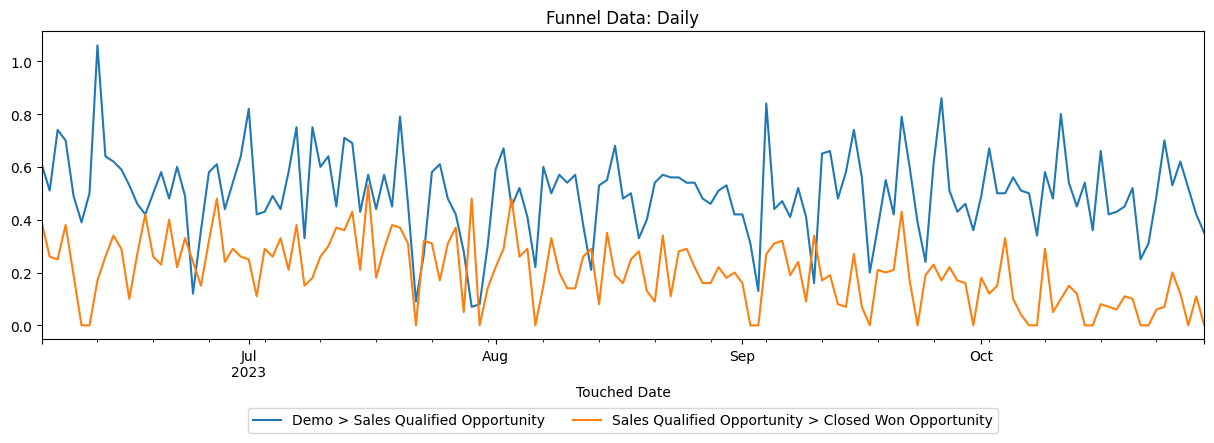

In [8]:
# Create copy of base df and rename
df_funnel_data_daily = df_conversion_data.copy()


#Group per day and agg kpis
df_funnel_data_daily = df_funnel_data_daily.groupby('Touched Date')[['# Demo Occurred','# Sales Qualified Opportunity','# Closed Won Opportunity']].sum().reset_index()


#Create funnel KPIs
df_funnel_data_daily['Demo > Sales Qualified Opportunity'] = round(df_funnel_data_daily['# Sales Qualified Opportunity'] / df_funnel_data_daily['# Demo Occurred'],2)
df_funnel_data_daily['Sales Qualified Opportunity > Closed Won Opportunity'] = round(df_funnel_data_daily['# Closed Won Opportunity'] / df_funnel_data_daily['# Sales Qualified Opportunity'],2)


#Set touched date as index
df_funnel_data_daily = df_funnel_data_daily.set_index('Touched Date')


#Plot data
fig = df_funnel_data_daily[['Demo > Sales Qualified Opportunity','Sales Qualified Opportunity > Closed Won Opportunity']].plot(figsize=(15,4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fancybox=True)
plt.title('Funnel Data: Daily')
plt.show()

### Weekly funnel data

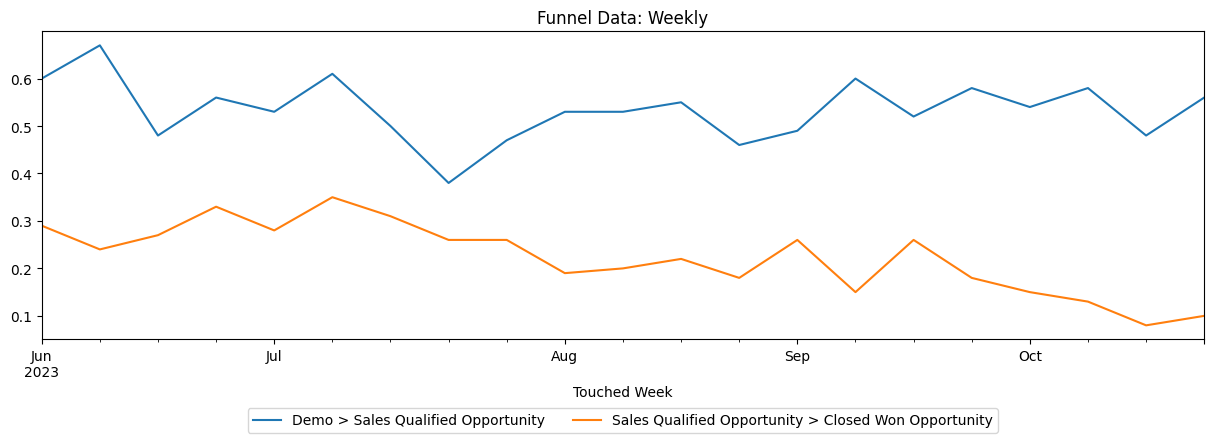

In [9]:
# Create copy of base df and rename
df_funnel_data_weekly = df_conversion_data.copy()

#Group per day and agg kpis
df_funnel_data_weekly = df_funnel_data_weekly.groupby('Touched Week')[['# Demo Occurred','# Sales Qualified Opportunity','# Closed Won Opportunity']].sum().reset_index()

#Create funnel KPIs
df_funnel_data_weekly['Demo > Sales Qualified Opportunity'] = round(df_funnel_data_weekly['# Sales Qualified Opportunity'] / df_funnel_data_weekly['# Demo Occurred'],2)
df_funnel_data_weekly['Sales Qualified Opportunity > Closed Won Opportunity'] = round(df_funnel_data_weekly['# Closed Won Opportunity'] / df_funnel_data_weekly['# Sales Qualified Opportunity'],2)

#Set touched date as index
df_funnel_data_weekly = df_funnel_data_weekly.set_index('Touched Week')

#Plot data
fig = df_funnel_data_weekly[['Demo > Sales Qualified Opportunity','Sales Qualified Opportunity > Closed Won Opportunity']].plot(figsize=(15,4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fancybox=True)
plt.title('Funnel Data: Weekly')
plt.show()

#### Analysis
- Daily data shows high variance, possible due to data seasonality
- Timeseries decomposition outside the scope of this question
- Weekly data shows:
    - Generally stable 'Demo > Sales Qualified Opportunity'
    - Decrease from 'Sales Qualified Opportunity > Closed Won Opportunity'

## c) CPA | Medium & Source combinations
- Calculate the Cost Per Acquisition (CPA) for UTM medium and source combinations that cost data is provided. How does the CPA vary across different marketing channels?

In [10]:
#Copy base df and rename (conversion data)
df_weekly_marketing_conversions = df_conversion_data.copy()


#Group conversion data per week / channel
df_weekly_marketing_conversions = df_weekly_marketing_conversions.groupby(['Touched Week','Utm Medium','Utm Source'])['# Closed Won Opportunity'].sum().reset_index()


#Copy base df and rename (marketing data)
df_marketing_data =  df_paid_platform_data.copy()


#Join dfs
df_marketing_data = df_marketing_data.merge(df_weekly_marketing_conversions, how='outer', left_on=('Traffic Week','Utm Medium','Utm Source'), right_on=('Touched Week','Utm Medium','Utm Source'))


#Aggregate data on a Utm Medium/Source level
df_marketing_data_agg = df_marketing_data.groupby(['Utm Medium','Utm Source'])[['$ Cost','# Closed Won Opportunity']].sum().reset_index()
df_marketing_data_agg = df_marketing_data_agg[df_marketing_data_agg['$ Cost'] > 0]
df_marketing_data_agg['cpa'] = round(df_marketing_data_agg['$ Cost'] / df_marketing_data_agg['# Closed Won Opportunity'],0)
df_marketing_data_agg = df_marketing_data_agg.reset_index(drop=True)

#Display results
df_marketing_data_agg.sort_values('cpa')

,Utm Medium,Utm Source,$ Cost,# Closed Won Opportunity,cpa
1,paid-search,google,19820244.0,1110.8,17843.0
0,paid-search,bing,906303.0,36.6,24762.0
2,paid-social,facebook,5243682.0,38.8,135146.0
3,paid-social,linkedin,6876231.0,30.9,222532.0


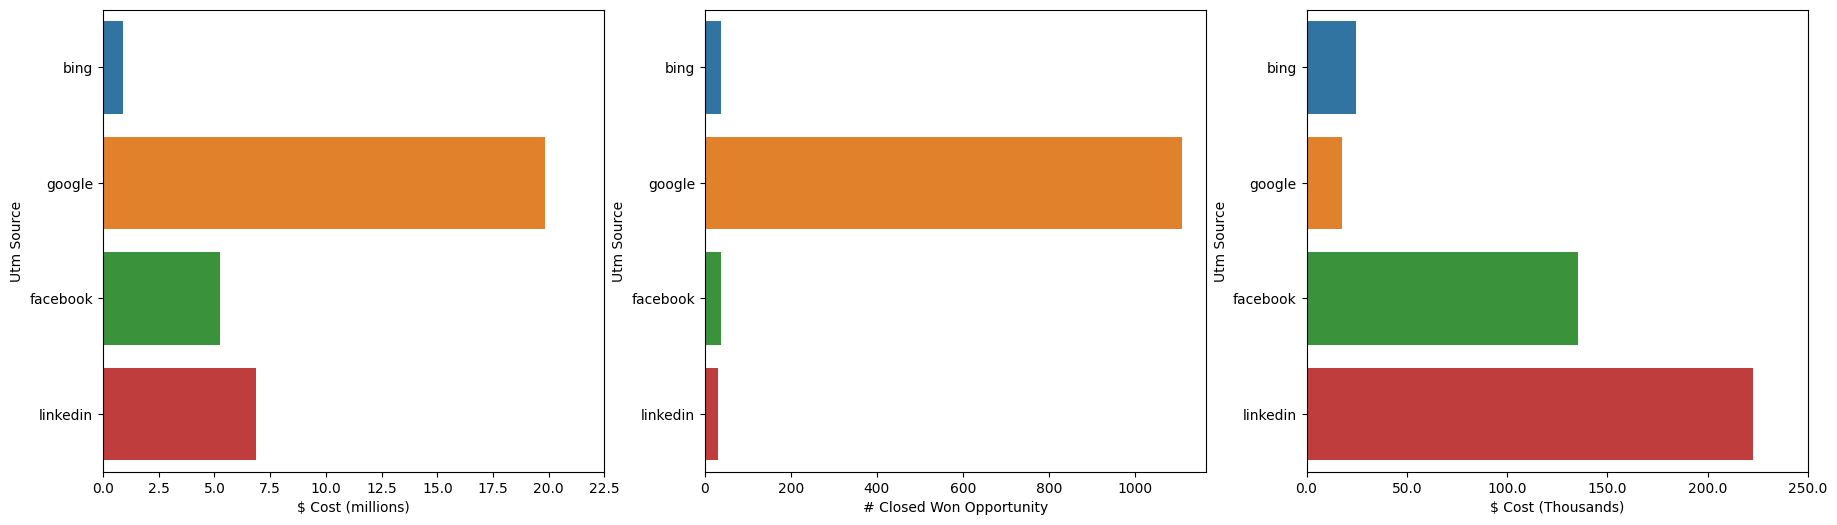

In [11]:
#Create fig
fig, [ax1, ax2, ax3]=plt.subplots(figsize=(22,6), nrows=1, ncols=3)


#Plot the 3 series
sns.barplot(data=df_marketing_data_agg, x='$ Cost', y='Utm Source', orient='h', ax=ax1)
sns.barplot(data=df_marketing_data_agg, x='# Closed Won Opportunity', y='Utm Source', orient='h', ax=ax2)
sns.barplot(data=df_marketing_data_agg, x='cpa', y='Utm Source', orient='h', ax=ax3)


#Format axis (ax1: cost in millions)
xlabels_ax1 = [f'{x/1000000}' for x in ax1.get_xticks()]
ax1.set_xticklabels(xlabels_ax1)
ax1.set_xlim(0,22500000)
ax1.set_xlabel("$ Cost (millions)")


#Format axis (ax3: cost in thousands)
xlabels_ax3 = [f'{x/1000}' for x in ax3.get_xticks()]
ax3.set_xticklabels(xlabels_ax3)
ax3.set_xlim(0,250000)
ax3.set_xlabel("$ Cost (Thousands)")


plt.show()

#### Analysis
- CPA's vary significantly:
    - Paid-search (€18,000-€25,000) significantly more efficient than paid-social (€135,000-€222,000)
- Google is by far the best performing paid channel, in terms of:
    - Scale ($ Cost) & Efficiency (CPA), driving the overwhelming majority of #closed won opportunities
- Bing, whilst less efficient and much less scaled than Google, is much more efficient CPA's than paid-social channels
- Facebook and Linkedin, based on this dataset, show decent scale at very low efficiency


## d) Funnel conversion rate
- Provide insights and recommendations on how to optimize the marketing strategy based on the sales funnel data
- Which channels or campaigns should be prioritized for future marketing efforts

In [12]:
#Copy base df and rename
df_funnel_data_extended = df_conversion_data.copy()


#Group dataset on on utm medum|source|campaign level
df_funnel_data_extended = df_funnel_data_extended.groupby(['Utm Medium','Utm Source', 'Utm Campaign'])[['# Demo Occurred','# Sales Qualified Opportunity','# Closed Won Opportunity']].sum().reset_index()


#Add column to label paid channels
df_funnel_data_extended['flag_paid_channel'] = df_funnel_data_extended['Utm Medium'].isin(['paid-search','paid-social'])


#Create funnel KPIs
df_funnel_data_extended['Demo > Sales Qualified Opportunity'] = round(df_funnel_data_extended['# Sales Qualified Opportunity'] / df_funnel_data_extended['# Demo Occurred'],2)
df_funnel_data_extended['Sales Qualified Opportunity > Closed Won Opportunity'] = round(df_funnel_data_extended['# Closed Won Opportunity'] / df_funnel_data_extended['# Sales Qualified Opportunity'],2)
df_funnel_data_extended['Demo > Closed Won Opportunity'] = round(df_funnel_data_extended['# Closed Won Opportunity'] / df_funnel_data_extended['# Demo Occurred'],2)


#Create df of paid channels
df_funnel_data_extended_paid = df_funnel_data_extended[df_funnel_data_extended['flag_paid_channel'] == True]

In [13]:
# Calculate average value, across all paid channels, of Demo > Closed Won Oppotunity
avg_demo_to_closed_won_opportunity = round(df_funnel_data_extended_paid['# Closed Won Opportunity'].sum() / df_funnel_data_extended_paid['# Demo Occurred'].sum(),3)
print(f"Avg Demo > Closed Won Opportunity: {avg_demo_to_closed_won_opportunity} ({avg_demo_to_closed_won_opportunity*100}%)")

Avg Demo > Closed Won Opportunity: 0.083 (8.3%)


In [15]:
df_funnel_data_extended_paid['Bidding Decision'] = df_funnel_data_extended_paid['Demo > Closed Won Opportunity'].apply(lambda x: 'Increase Bid' if x > avg_demo_to_closed_won_opportunity else 'Decrease Bid')

#Top 20 Campaigns for bid increase
top_campaigns_to_increase_bids = df_funnel_data_extended_paid[df_funnel_data_extended_paid['Bidding Decision'] == 'Increase Bid'].sort_values('# Closed Won Opportunity', ascending=False).head(10)
top_campaigns_to_increase_bids = top_campaigns_to_increase_bids.drop(columns={'Utm Medium','flag_paid_channel'})

#Top 20 Campaigns for bid decrease
top_campaigns_to_decrease_bids = df_funnel_data_extended_paid[df_funnel_data_extended_paid['Bidding Decision'] == 'Decrease Bid'].sort_values('# Closed Won Opportunity', ascending=False).head(10)
top_campaigns_to_decrease_bids = top_campaigns_to_decrease_bids.drop(columns={'Utm Medium','flag_paid_channel'})

In [16]:
top_campaigns_to_increase_bids.head(3)

,Utm Source,Utm Campaign,# Demo Occurred,# Sales Qualified Opportunity,# Closed Won Opportunity,Demo > Sales Qualified Opportunity,Sales Qualified Opportunity > Closed Won Opportunity,Demo > Closed Won Opportunity,Bidding Decision
558,google,nam-t1_acq_searchbrand_google_search_broad--__all,1854.6,1427.7,299.0,0.77,0.21,0.16,Increase Bid
441,google,emea-t1a_acq_searchbrand_google_search_broad--...,930.8,657.6,151.5,0.71,0.23,0.16,Increase Bid
573,google,nam-t1_acq_searchnonbranded_google_search_coun...,399.1,238.7,36.0,0.60,0.15,0.09,Increase Bid


In [17]:
top_campaigns_to_decrease_bids.head(3)

,Utm Source,Utm Campaign,# Demo Occurred,# Sales Qualified Opportunity,# Closed Won Opportunity,Demo > Sales Qualified Opportunity,Sales Qualified Opportunity > Closed Won Opportunity,Demo > Closed Won Opportunity,Bidding Decision
459,google,emea-t1a_acq_searchnonbranded_google_search_pa...,352.9,168.6,18.2,0.48,0.11,0.05,Decrease Bid
578,google,nam-t1_acq_searchnonbranded_google_search_payr...,501.4,136.1,15.8,0.27,0.12,0.03,Decrease Bid
574,google,nam-t1_acq_searchnonbranded_google_search_eor-...,320.1,157.3,13.5,0.49,0.09,0.04,Decrease Bid


#### Analysis & Recommendations

##### Assumptions
- There is a scale <> efficiency trade off in marketing
- Easiest way to control this is by increasing / decrease campaign bids

##### Strategy
- We want to spend more on efficient campaigns and spend less on inefficient campaigns
- Ideally we would use the campaign ROAS
- We will use 'Demo > Closed Won Opportunity rate' as a proxy

##### Approach
- We limit our dataset to paid-search and paid-social
- We calculate the average 'Demo > Closed Won Opportunity rate' for the entire dataset
- We then compare the campaign level 'Demo > Closed Won Opportunity rate' with average
    - If the campaign value is above the average: Increase Bids
    - If the campaign value is below the average: Decrease Bids
    

##### In practice
- More sophisticated bidding decisions, which consider scale (spend) and also maintain the current bid, instead of exclusively increasing/decrease
- Incorporate marketing spend and base bidding decisions on campaign efficiency (ROAS / CPA)

# Task 2: Paid Marketing Channel Analysis

### a) Paid Channel CTR Analysis
- Calculate the click-through rate (CTR) for each of the four paid marketing channels on a weekly basis
- Visualize the CTR trends over time and identify any significant fluctuations.

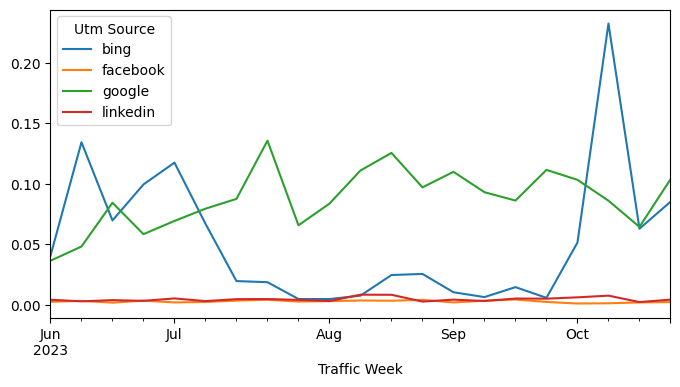

In [18]:
#Copy base df and rename
df_paid_ctr = df_paid_platform_data.copy()

#Calculate CTR
df_paid_ctr['ctr'] = round(df_paid_ctr['# Clicks'] / df_paid_ctr['# Impressions'],4)

#Pivot data
df_paid_ctr = df_paid_ctr[['Traffic Week','Utm Source', 'ctr']].pivot_table(columns='Utm Source', values='ctr', index='Traffic Week').reset_index().set_index('Traffic Week')

#Display data
df_paid_ctr.plot(figsize=(8,4))
plt.show()

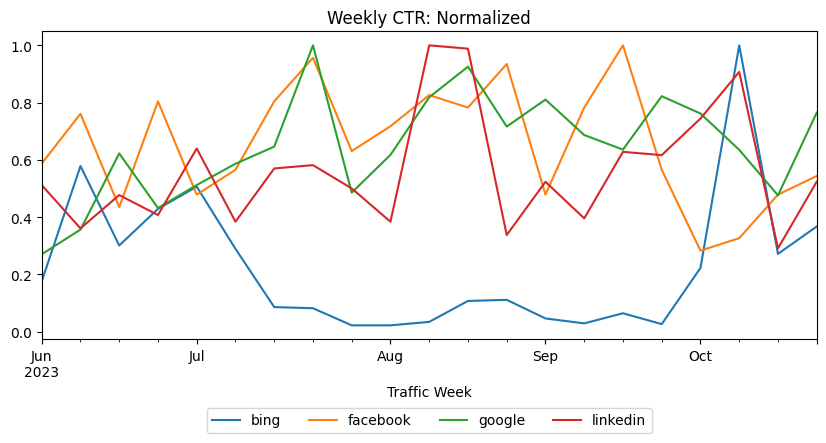

In [19]:
#Normalize Data
df_paid_ctr_normalized = df_paid_ctr / df_paid_ctr.max(axis=0)

#Display data
df_paid_ctr_normalized.plot(figsize=(10,4))
plt.title('Weekly CTR: Normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fancybox=True)
plt.show()

#### Analysis
- Non-Normalized data fails to provide clear answers
- Normalized data shows quite high fluctations, although fluctuations don't appear unusual
    - Exception for Bing, where CTR's significantly fall mid-July before increasing at the end of September

## b) Budget allocation 
- Provide recommendations on how to allocate the marketing budget effectively based on the analysis of the paid marketing channels. 
- Which channels should receive more budget, and which ones should be scaled back?

In [20]:
#Copy base df (marketing platform data) and rename 
df_marketing_data_extended = df_paid_platform_data.copy()


#Copy base df (conversion data) and rename
df_weekly_marketing_conversions = df_conversion_data.copy()


#Conversion data: group to align level with marketing data_set
df_weekly_marketing_conversions = df_weekly_marketing_conversions.groupby(['Touched Week','Utm Medium','Utm Source'])[['# Closed Won Opportunity','# Demo Occurred']].sum().reset_index()


#Create consolodated marketing data set
df_marketing_data_extended = df_marketing_data_extended.merge(df_weekly_marketing_conversions, how='left', left_on=('Traffic Week','Utm Medium','Utm Source'), right_on=('Touched Week','Utm Medium','Utm Source'))



#From consolodated marketing data set: aggregate data to get total kpis over the entire period
df_marketing_data_extended_agg = df_marketing_data_extended.groupby('Utm Source')[['# Impressions','# Clicks','$ Cost','# Closed Won Opportunity','# Demo Occurred']].sum().reset_index()


#Create function to calculate marketing kpis (cpa, ctr, cpm, demo_to_closed_opportunity)
def calculate_marketing_kpis(df):
    df['cpa'] = round(df['$ Cost'] / df['# Closed Won Opportunity'],0)
    df['ctr'] = round(df['# Clicks'] / df['# Impressions'],4)
    df['cpm'] = round(df['$ Cost'] / df['# Impressions'],4)*1000
    df['Demo > Closed Won Opportunity'] = round(df['# Closed Won Opportunity'] / df['# Demo Occurred'],2)
    return df

#Apply function and calculate marketing KPIs for both datasets (agg & non-agg)
df_marketing_data_extended = calculate_marketing_kpis(df=df_marketing_data_extended)
df_marketing_data_extended_agg = calculate_marketing_kpis(df=df_marketing_data_extended_agg)

#df_marketing_data_extended_agg

### Plot weekly CPA per channel

<Axes: xlabel='Touched Week'>

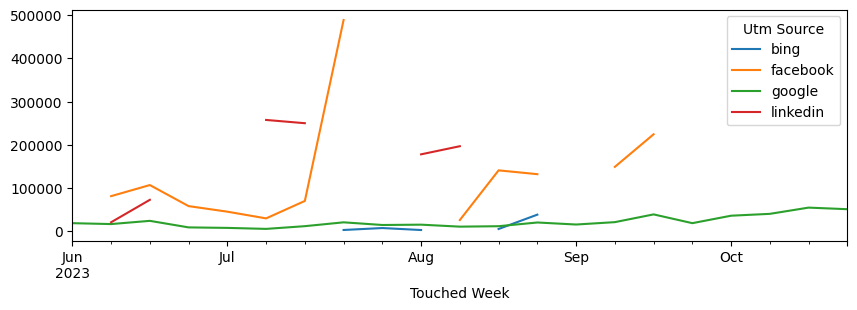

In [21]:
df_marketing_data_extended.pivot_table(columns='Utm Source',  index='Touched Week',values='cpa').plot(figsize=(10,3))

### Plot aggregated KPIs per channel

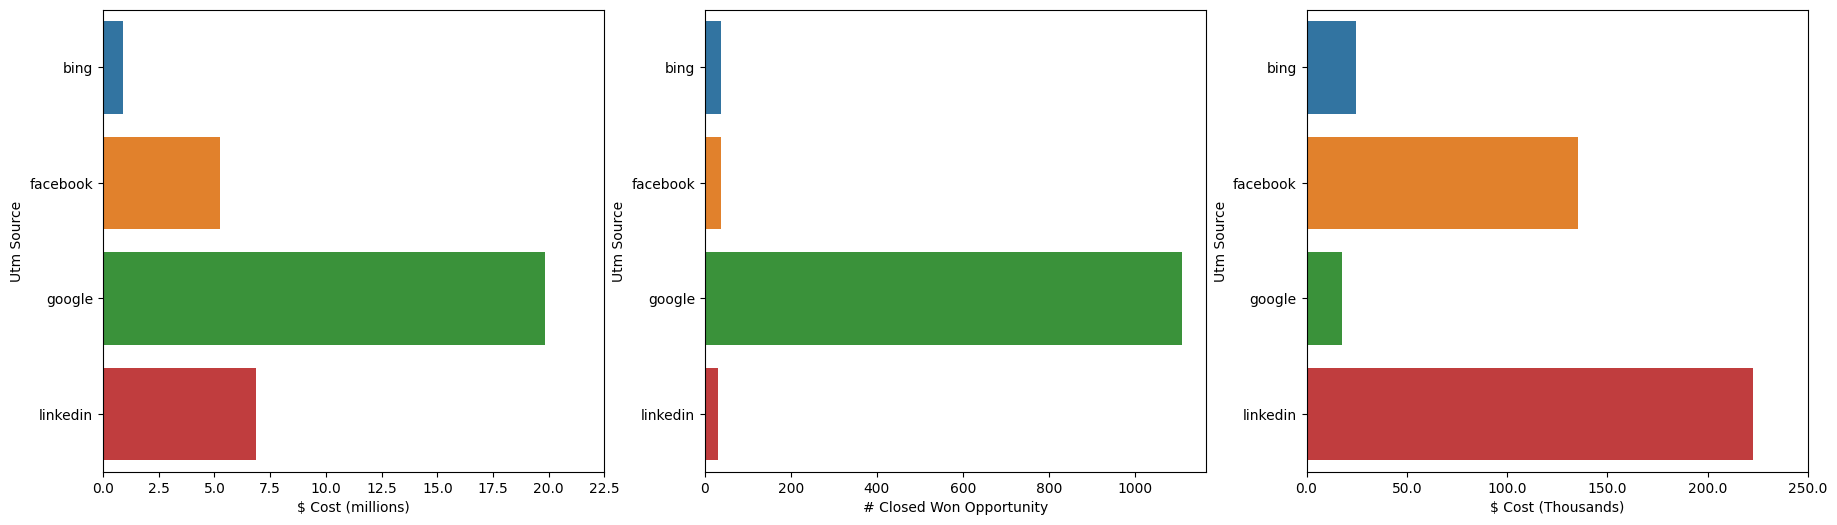

In [22]:
#Create fig
fig, [ax1, ax2, ax3]=plt.subplots(figsize=(22,6), nrows=1, ncols=3)


#Plot the 3 series
sns.barplot(data=df_marketing_data_extended_agg, x='$ Cost', y='Utm Source', orient='h', ax=ax1)
sns.barplot(data=df_marketing_data_extended_agg, x='# Closed Won Opportunity', y='Utm Source', orient='h', ax=ax2)
sns.barplot(data=df_marketing_data_extended_agg, x='cpa', y='Utm Source', orient='h', ax=ax3)


#Format axis (ax1: cost in millions)
xlabels_ax1 = [f'{x/1000000}' for x in ax1.get_xticks()]
ax1.set_xticklabels(xlabels_ax1)
ax1.set_xlim(0,22500000)
ax1.set_xlabel("$ Cost (millions)")


#Format axis (ax3: cost in thousands)
xlabels_ax3 = [f'{x/1000}' for x in ax3.get_xticks()]
ax3.set_xticklabels(xlabels_ax3)
ax3.set_xlim(0,250000)
ax3.set_xlabel("$ Cost (Thousands)")


plt.show()

##### Assumptions:
- Data is based on an attribution model, which fairly attributes conversions - also towards early journey channels
- Data is correct, given LinkedIn CPA is incredibly high

##### Recommendations
- Significantly reduce paid-social budgets (linkedin & facebook)
- Increase budgets for paid-search:
    - Majority going towards 'google' given the scale opportunities over bing
  

## c) Budget allocation: Measuring effectiveness
- How would you track and monitor the effectiveness of the revised budget allocation strategy over time? 
- What key performance indicators (KPIs) would you use to measure success?

In [23]:
#Copy base df and rename
df_budget_allocation_monitoring = df_marketing_data_extended.copy()

#Group df
df_budget_allocation_monitoring = df_budget_allocation_monitoring.groupby('Traffic Week')[['$ Cost','# Closed Won Opportunity']].sum().reset_index()

#Calculate cpa
df_budget_allocation_monitoring['cpa'] = round(df_budget_allocation_monitoring['$ Cost'] / df_budget_allocation_monitoring['# Closed Won Opportunity'],0)

#Display results
df_budget_allocation_monitoring.head(3)

,Traffic Week,$ Cost,# Closed Won Opportunity,cpa
0,2023-06-05,1481891.0,49.4,29998.0
1,2023-06-12,1464711.0,72.2,20287.0
2,2023-06-19,2060174.0,62.3,33069.0


##### Analysis

- Ultimately we  need to monitor our '$ Cost', '#Cosed Won Opportunities' and 'CPA'
- A increase in efficiency, through a lower CPA, is the primary KPI to monitor here
- We would monitor this metric over time and expect a downward trend, beginning once the new strategy is implemented


##### Additional Considerations
- Most likely the marketing strategy aims to maximise efficiency whilst maintaining a certain amount of #Closed Won Opportunity'
    - As such a secondary KPI to monitor would '# Closed Won Opportunity'
    
    
##### General Point
- Performance marketing typically has to consider all 3 elements (Scale, Conversions/Revenue & Efficiency)

## d) Cost <> Sales Funnel Conversion Relationship
- Visualize the relationship between cost and sales funnel conversions over time
- Are there any noticeable patterns or trends?

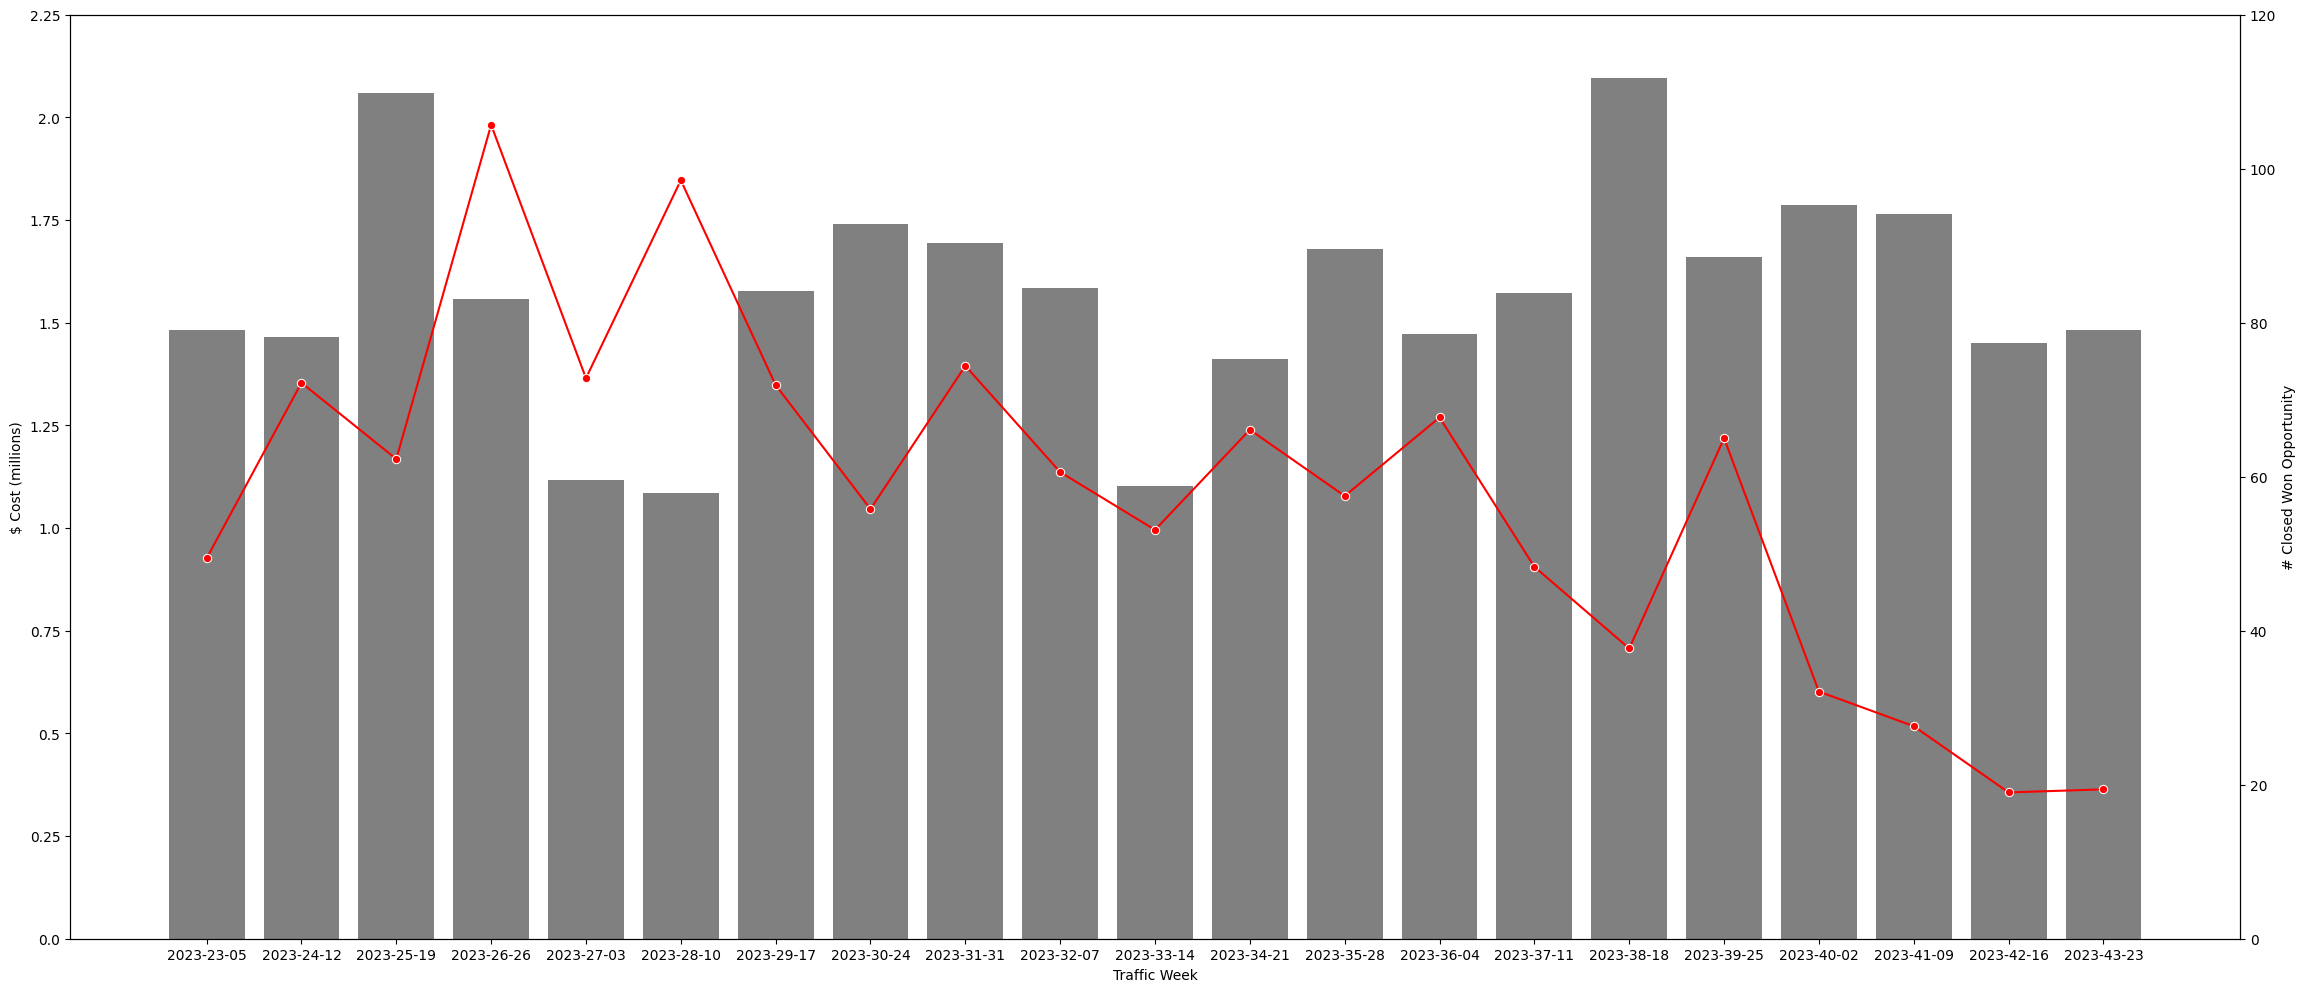

In [24]:
#Copy base df and rename
df_cost_sales_funnel = df_budget_allocation_monitoring.copy()


#Format date
df_cost_sales_funnel['Traffic Week'] = df_cost_sales_funnel['Traffic Week'].apply(lambda x: x.strftime('%Y-%W-%d'))


#Create fig
fig, ax1=plt.subplots(figsize=(28,12))


#Plot cost data as bar chart
sns.barplot(data=df_cost_sales_funnel, x='Traffic Week', y='$ Cost', color='grey', ax=ax1)


#Plot Sales Funnel Conversion Data over time
ax2 = plt.twinx()
sns.lineplot(data=df_cost_sales_funnel, x='Traffic Week', y='# Closed Won Opportunity', color='red', ax=ax2, marker='o')

#Format yaxis
ylabels_ax1 = [f'{x/1000000}' for x in ax1.get_yticks()]
ax1.set_yticklabels(ylabels_ax1)
ax1.set_ylim(0,2250000)
ax1.set_ylabel("$ Cost (millions)")

#Format xaxis
ax2.set_ylim(0,120)

#Display data
plt.show()

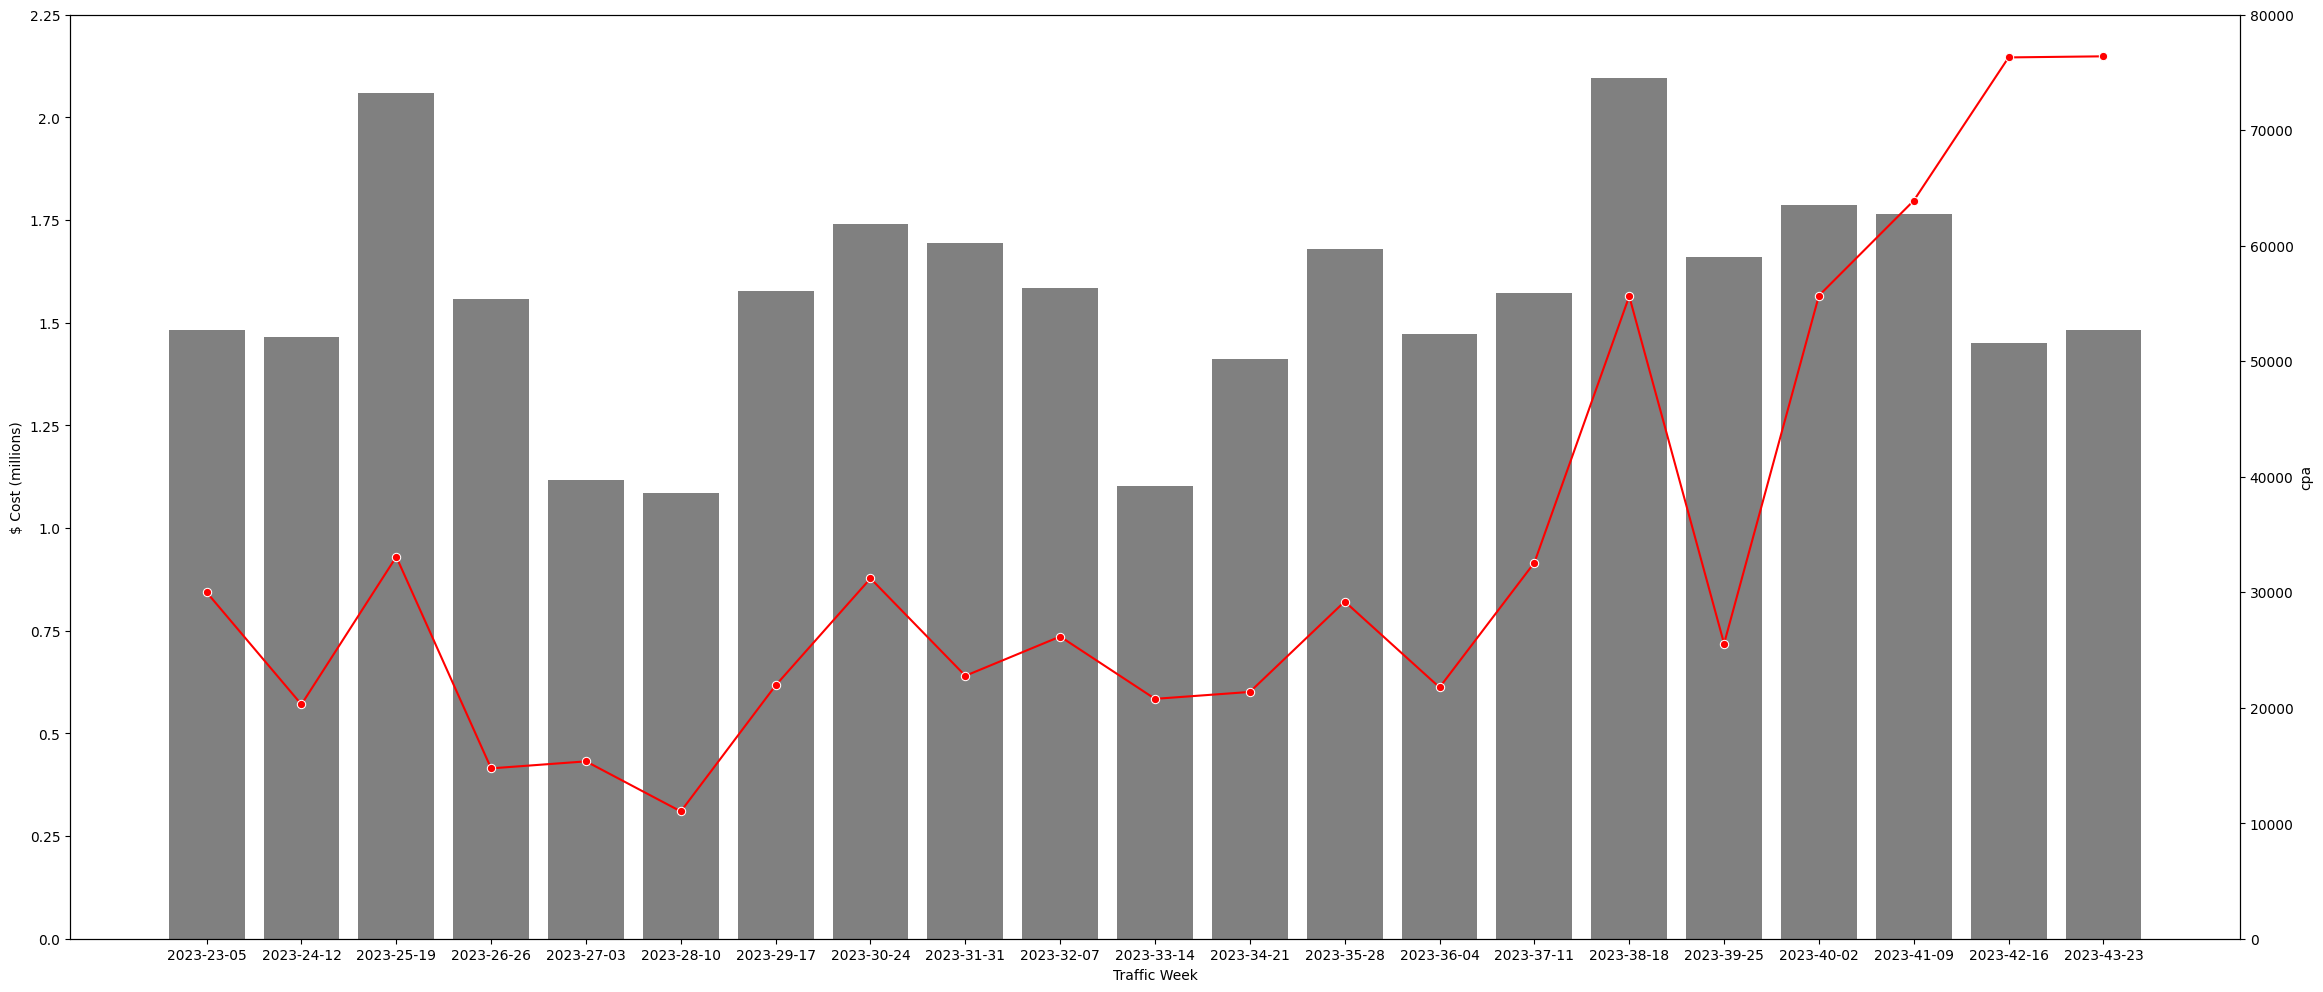

In [25]:
#Create fig
fig, ax1=plt.subplots(figsize=(28,12))


#Plot cost data as bar chart
sns.barplot(data=df_cost_sales_funnel, x='Traffic Week', y='$ Cost', color='grey', ax=ax1)


#Plot Sales Funnel Conversion Data over time
ax2 = plt.twinx()
sns.lineplot(data=df_cost_sales_funnel, x='Traffic Week', y='cpa', color='red', ax=ax2, marker='o')

#Format yaxis
ylabels_ax1 = [f'{x/1000000}' for x in ax1.get_yticks()]
ax1.set_yticklabels(ylabels_ax1)
ax1.set_ylim(0,2250000)
ax1.set_ylabel("$ Cost (millions)")

#Format xaxis
ax2.set_ylim(0,80000)

#Display data
plt.show()

#### Comments
- Given that spend is stable / trending upwards, whilst Closed Won Opportunities are significantly decreasing:
    - CPA's are rising significantly
    
- Depending on business strategy, if we want to increase our efficiency:
    - We should decrease spend / allocate spend towards more efficient channels

# Task 3: General Questions

### a) Missing Values
- Are there any data quality issues or missing values in the datasets? How would you handle them if you found any?

In [26]:
#For df_paid_conversion_data: Create dataFrame for each row with null value
df_conversion_data_rows_containg_null = df_conversion_data[df_conversion_data.isnull().any(axis=1)]
df_conversion_data_rows_containg_null.head(3)

,Touched Date,Utm Medium,Utm Source,Utm Campaign,# Demo Occurred,# Sales Qualified Opportunity,# Closed Won Opportunity,Touched Week
5,2023-10-29,email-newsletter,inside.com,NaN,0.0,0.0,0.0,2023-10-23
31,2023-10-29,referral,deel.com,NaN,2.6,3.2,0.0,2023-10-23
77,2023-10-28,referral,deel.com,NaN,0.6,0.6,0.0,2023-10-23


In [27]:
#Drop utm campaign and recalculate
df_conversion_data_rows_containg_null = df_conversion_data[df_conversion_data.drop(columns={'Utm Campaign'}).isnull().any(axis=1)]
df_conversion_data_rows_containg_null.head(3)

,Touched Date,Utm Medium,Utm Source,Utm Campaign,# Demo Occurred,# Sales Qualified Opportunity,# Closed Won Opportunity,Touched Week


In [28]:
#For df_platform_data: Create dataFrame for each row with null value
df_paid_platform_data_rows_containing_null = df_paid_platform_data[df_paid_platform_data.isnull().any(axis=1)]
df_paid_platform_data_rows_containing_null.head(3)

,Utm Medium,Utm Source,Traffic Week,# Impressions,# Clicks,$ Cost


### Comments
---
#### Data Quality
Data quality appears to be generally quite good, despite some issues and unusual observations

1. There are some formatting issues, which need to be dealt with, in order to work with the data:
- Cost data isn't numerical
- Date's aren't always datetime format

2. Null Values:
- Beyond the Utm Campaign, there are no null values in the entire dataset


3. Bing CTR:
- CTR drop is so significant that it would require an investigation in click / impressions to ensure the data is accurate

4. Linkedin CPA
- Intuitively the value seems much too high


#### Dealing with missing values
Can have significant impact on our analysis and therefore needs to be dealt with. Some solutions:

- Drop missing / null values
- Replace missing / null values with an average
    - More sophisticated might be replacing with the forecasted trend (Can be overkill in many situations)

### b) Outliers
- How would you handle outliers in the data? Are there any outliers in the provided datasets?

In [29]:
#Calculate zscore for each funnel kpi
df_conversion_data['# Demo Occurred: Outlier'] = np.abs(stats.zscore(df_conversion_data['# Demo Occurred'])>3)
df_conversion_data['# Sales Qualified Opportunity: Outlier'] = np.abs(stats.zscore(df_conversion_data['# Sales Qualified Opportunity'])>3)
df_conversion_data['# Closed Won Opportunity: Outlier'] = np.abs(stats.zscore(df_conversion_data['# Closed Won Opportunity'])>3)
df_conversion_data_outliers = df_conversion_data[(df_conversion_data['# Demo Occurred: Outlier'] == True) | (df_conversion_data['# Sales Qualified Opportunity: Outlier'] == True) | (df_conversion_data['# Closed Won Opportunity: Outlier'])]


#Group outliers by utm source
df_conversion_data_outliers_agg = df_conversion_data_outliers.groupby('Utm Source')[['# Demo Occurred: Outlier','# Sales Qualified Opportunity: Outlier','# Closed Won Opportunity: Outlier']].sum().reset_index()


#Sort values and show top 5
df_conversion_data_outliers_agg.sort_values(by='# Demo Occurred: Outlier', ascending=False).head(5)

,Utm Source,# Demo Occurred: Outlier,# Sales Qualified Opportunity: Outlier,# Closed Won Opportunity: Outlier
9,google,143,127,80
26,tradeshow-sponsorship,13,16,12
22,peoplemanagingpeople,5,6,4
8,facebook,4,2,0
10,hosted-deel-event,3,6,11


### Comments
---

##### Zscore (Normal Distributions)
- Common approach to deal with outliers is using a zscore, which calculates the standard deviation from mean, for each value
- Essentially, we calculate how far each value is from the average
- Assuming the data follows a normal distribution, we would deem zscores greater than 3, as extreme outliers


##### Excluding outliers
- Based on the zscore the majority of outliers are from google
- Given that google, by far, is the best performing channel, these values are probably not outliers which we should remove
- Removing these values would, incorrectly, distort the entire analysis


#### Notes
- This is assumes the data is normally distributed, which was not tested in this analysis
- One consideration was to calculate a zscore, within each UTM source, which most likely would have kept all of the Google outliers. This wasn't done due to time constraints
- There are additional approaches to dealing with outliers, that weren't considered due to time constraints


### c) Key Takeaways
- Summarize the key takeaways and actionable recommendations from your analysis for a non-technical audience.


##### 1. Our sales funnel data has high  seasonality
- Demos / Sales Opportunities / Closed Opportunites occur Mon-Fri, not at the weekend
- Disproportionately allocate budgets to the working week

##### 2. The beginning of the month has less activety
- Demos / Sales Opportunities / Closed Opportunites are low at the start of the month
- Allocate a larger share of the budget between the middle to the end of the month

##### 3. Our lower funnel (Sales Opportunities > Closed Opportunities) has been decreasing significantly
- Investigate underlying issues, and consider reducing marketing spend, allocating larger budgets to more active periods during the year


##### 4. CPAs: Paid-Search > Paid-Social, Google is King
- CPAs for paid-social are extremely high, and despite the significant spend, drive few closed opportunities
- Allocate budget away from Linkedin & Facebook and paid-social (predominantly Google)
- Google, by far, has the best scale and is the most efficient channel


##### 5. Stable spend, declining closed won opportunties = Rising CPAs
- Whilst spend is stable / moderately increasing, our lower funnel drop is leading to far fewer closed opportunities
- CPAs are rising significantly

### d) Attribution models
- How would you describe how marketing attribution models work? Note: this is a general question, not related to Deel or the dataset you have worked on for this task


##### General
An attribution model is the set of rules which determines how much each conversion / revenue should be allocated towards each step within the conversion path

##### Marketing Context
- Within a marketing context, an attribution model ensures that each marketing channel with which a user has engaged with, get's it's according share of the final conversion / revenue


###### First / Last Touch
- At the most basic level, we can attribute the conversion / revenue to the first / last marketing channel within the conversion journey. This comes with significant limitations, given that often we might be exposed to an ad on social media, before googling the product/service at a later stage. Clearly both channels played a significant role in conversion path.


##### Linear
- Here we assign each step within the conversion journey an equal share


##### Bathtub Attribution
- Here we assign the first and last touch each 40%, and attribute the remaining 20% on the steps inbetween the first and last touch.
- When there are 2 steps, each is attriuted 50%
- This model is already a significant improvement on first/last/linear models in that it incorporates larger weighting to the driving initial / closing touchpoints, whilst ensuring the touchpoints inbetween are accounted for.

###### Probabilistic Attribution Modelling
- Given the move away from App Tracking and Cookies, it is getting increasingly difficult to identify users across their conversion journeys.
- Probabilistic attribution is a form of attribution modelling based on probabilities, rather than user identifiers.  Machine learning and statistical modelling techniques are used to identify probable conversions across various marketing touchpoints.
- There is a significantly more complexity in both setup, maintenance and interpretation for non-technical stakeholders


### e) Attribution model proposal
- What attribution model do you propose for our business?

###### Probabalistic Attribution Modelling
- Given the resources available at Deel, there would be value in having a probablistic attribution model which relies on Machine Learning and statistical modelling. Not only does this deal with the issue regarding the move away from cookies, but can also incorporate out-of-home advertising, in-person events and TV in a way that a classic user identifier model cannot.


- If this isn't possible, Deel should incorporate a Bathtub Attribution model, based on server-side tracking, to minimise the impact away from cookies